C:\Users\avnit\Anaconda3\lib\site-packages\deap\creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
C:\Users\avnit\Anaconda3\lib\site-packages\deap\creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


-- Generation 0 --
  Min 0.4337245151489531
  Max 2.7738735050143437
  Avg 0.9855104717076678
  Std 0.3180487440824764
-- Generation 1 --
  Min 0.4112027678437573
  Max 2.225930565212586
  Avg 0.8481660297809379
  Std 0.2678309392293416
-- Generation 2 --
  Min 0.4112027678437573
  Max 2.1134173679263952
  Avg 0.7885566484477502
  Std 0.29558939602921175
-- Generation 3 --
  Min 0.15928411273179102
  Max 1.6979873012312805
  Avg 0.7095976072819625
  Std 0.28783051269606025
-- Generation 4 --
  Min 0.15928411273179102
  Max 1.7650816057484113
  Avg 0.6586323350487399
  Std 0.3001763778480694
-- Generation 5 --
  Min 0.15928411273179102
  Max 2.225930565212586
  Avg 0.579833520702859
  Std 0.2865551260228827
-- Generation 6 --
  Min 0.159284112731791
  Max 2.225930565212586
  Avg 0.5772743343237672
  Std 0.3027207667540295
-- Generation 7 --
  Min 1.3010379810451123e-16
  Max 1.913330089660416
  Avg 0.5510596544833738
  Std 0.32738292693728377
-- Generation 8 --
  Min 1.3010379810451123e

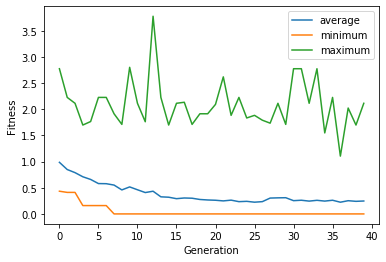

In [2]:
#Genetic Program
#Relative Imports
import random
import operator

import numpy as np
import matplotlib.pyplot as plt

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

import random
import operator

import numpy as np
import matplotlib.pyplot as plt

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

#Creating fitness and individual classes
#Individual inherits from tree 
creator.create("FitnessMin", base.Fitness, weights = (-1.0, ))
creator.create("Individual", gp.PrimitiveTree, fitness = creator.FitnessMin)

#Initialize primitive set
#arity defines amount of arguments each primitive takes
#rename default argument name from ARG0 to x
pset = gp.PrimitiveSet("MAIN", arity=1)
pset.addPrimitive(np.add, arity=2)
pset.addPrimitive(np.subtract, arity=2)
pset.addPrimitive(np.multiply, arity=2)
pset.addPrimitive(np.negative, arity=1)
pset.renameArguments(ARG0='x')
#TODO - add new primitives
##pset.addPrimitive()
##pset.addPrimitive()

#define toolbox, individual, population, and compiler
#ephemeral - register random function as a terminal ie randint
#gp.genHalfAndHalf returns primitve tree nbased on primitive sent and max/min tree set

toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset = pset, min_=1, max_ = 2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

#Evaluation Function
#compile tree into function, calculate function + determine mean squared error
#try to minimize mean square error; attempting to fin d the best combination of primitives given objectives to minimize or maximize
def evalSymbReg(individual, points, pset):
    func = gp.compile(expr=individual, pset=pset)
    sqerrors = (func(points)-(points**4 + points**3 + points**2 + points))**2
    return (np.sqrt(np.sum(sqerrors) / len(points)),)

#register genetic operators
toolbox.register("evaluate", evalSymbReg, points=np.linspace(-1, 1, 1000), pset=pset)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

#TODO - Add one more mutation method
##toolbox.register()

#Add tree height constraints to mutation
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

#main evolutionary algorithm

gen = range(40)
gen = range(40)
avg_list = []
max_list = []
min_list = []

pop = toolbox.population(n=300)

# Evaluate the entire population
fitnesses = list(map(toolbox.evaluate, pop))
for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit

# Begin the evolution
for g in gen:
    print("-- Generation %i --" % g)

    # Select the next generation individuals
    offspring = toolbox.select(pop, len(pop))
    # Clone the selected individuals
    offspring = list(map(toolbox.clone, offspring))

    # Apply crossover and mutation on the offspring
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < 0.5:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    for mutant in offspring:
        if random.random() < 0.2:
            toolbox.mutate(mutant)
            del mutant.fitness.values

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    # Replace population
    pop[:] = offspring

    # Gather all the fitnesses in one list and print the stats
    fits = [ind.fitness.values[0] for ind in pop]

    length = len(pop)
    mean = sum(fits) / length
    sum2 = sum(x*x for x in fits)
    std = abs(sum2 / length - mean**2)**0.5
    g_max = max(fits)
    g_min = min(fits)
        
    avg_list.append(mean)
    max_list.append(g_max)
    min_list.append(g_min)

    print("  Min %s" % g_min)
    print("  Max %s" % g_max)
    print("  Avg %s" % mean)
    print("  Std %s" % std)

print("-- End of (successful) evolution --")

best_ind = tools.selBest(pop, 1)[0]
print("Best individual is %s, %s" % (best_ind, best_ind.fitness.values))

#graphing
plt.plot(gen, avg_list, label="average")
plt.plot(gen, min_list, label="minimum")
plt.plot(gen, max_list, label="maximum")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend(loc="upper right")
plt.show()
